**Step Process Data Analysis**

While we won't be able to log data and add print statements to vLLM in production code, an initial data analysis of how scheduling, executiong, and post processing times scale is relevant to understand where time of execution varies the most

(In vLLM core.py)
```python
        timestart = time.time()
        ### Scheduling Phase
        if not self.scheduler.has_requests():
            return {}, False
        scheduler_output = self.scheduler.schedule()
        ### End of Scheduling Phase
        timeend = time.time()
        scheduler_time = timeend - timestart



        timestart = time.time()
        ### Execution Phase
        model_output = self.execute_model(scheduler_output)
        ### End of Execution Phase
        timeend = time.time()
        execute_time = timeend - timestart

        timestart = time.time()
        ### Post-processing Phase
        engine_core_outputs = self.scheduler.update_from_output(
            scheduler_output, model_output)  # type: ignore
        ### End of Post-processing Phase
        timeend = time.time()
        update_time = timeend - timestart
```

We store the results in a csv for processing (execution_stats.csv)

In [49]:
# load csv in pandas
import pandas as pd
from utils import parse_csv, format_data, concatenate_dataframes # found in utils.py

path1 = 'profiling/train'

# # parse and concat all dataframes
df = concatenate_dataframes(path1)
df = format_data(df)
df.head()

,num_total_scheduled_tokens,execute_time,scheduler_time,update_time,arrival_rate,time_stamp,loop_time,loop_step_time,loop_queue_time,sum_cached_prefill_tokens,max_cached_prefill_tokens,num_prefills,sum_decode_tokens,sum_uncached_prefill_tokens,max_uncached_prefill_tokens,sum_prefill_tokens,max_prefill_tokens,num_total_requests
0,9,0.005915,0.000495,0.000076,25,0.756947,NaN,NaN,NaN,720,720,1,0,9,9,729,729,1
1,0,0.000115,0.000269,0.000004,25,0.764686,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
2,9,0.005589,0.000320,0.000030,25,0.773088,NaN,NaN,NaN,0,0,1,0,9,9,9,9,1
3,1,0.005482,0.000265,0.000032,25,0.779872,NaN,NaN,NaN,0,0,0,1,0,0,0,0,1
4,1,0.005515,0.000252,0.000031,25,0.786536,NaN,NaN,NaN,0,0,0,1,0,0,0,0,1


In [48]:
df['loop_time'].to_csv("loop_time.csv", index=False)

In [37]:
print("Total time", df['loop_time'].mean())
print("Loop queue time", df['loop_queue_time'].mean())
print("Loop queue time stdev", df['loop_queue_time'].std())
print("Loop step time median", df['loop_step_time'].median())
print("Loop step time", df['loop_step_time'].mean())
print("Step time", (df['scheduler_time'] + df['execute_time'] + df['update_time']).mean())
print("Step scheduler time", df['scheduler_time'].mean())
print("Step execution time", df['execute_time'].mean())
print("Step update time", df['update_time'].mean())

Total time 0.008018576032747048
Loop queue time 0.001998795968730275
Loop queue time stdev 0.049838499687067044
Loop step time median 0.0059874057769775
Loop step time 0.006019780064016774
Step time 0.005997211467928905
Step scheduler time 0.0002938964502597731
Step execution time 0.005670154724663786
Step update time 3.3160293005346285e-05


In [52]:
# average update_time and scheduler_time
avg_update_time = df['update_time'].mean()
std_update_time = df['update_time'].std()
avg_scheduler_time = df['scheduler_time'].mean()
std_scheduler_time = df['scheduler_time'].std()
print(f"Average update_time: {avg_update_time}")
print(f"Standard deviation of update_time: {std_update_time}")
print(f"Average scheduler_time: {avg_scheduler_time}")
print(f"Standard deviation of scheduler_time: {std_scheduler_time}")

Average update_time: 0.00011448486525006863
Standard deviation of update_time: 0.00010086473571098507
Average scheduler_time: 0.0006822544617893898
Standard deviation of scheduler_time: 0.0021558622585287216


In [53]:
# for each iteration get the percentage of the execute_time, scheduler_time, and update_time over the total time (total_time = execute_time + scheduler_time + update_time)

df['total_time'] = df['loop_time']

df['loop_step_time_pct'] = (df['loop_step_time'] / df['total_time'])
df['loop_queue_time_pct'] = (df['loop_queue_time'] / df['total_time'])

df['execute_time_pct'] = (df['execute_time'] / df['total_time'])
df['scheduler_time_pct'] = (df['scheduler_time'] / df['total_time'])
df['update_time_pct'] = (df['update_time'] / df['total_time'])
df['internal_step_time_pct'] = (df['execute_time'] + df['scheduler_time'] + df['update_time']) / df['total_time']
# average the percentages
avg_loop_step_time_pct = df['loop_step_time_pct'].mean()
avg_loop_queue_time_pct = df['loop_queue_time_pct'].mean()
avg_internal_step_time_pct = df['internal_step_time_pct'].mean()
avg_execute_time_pct = df['execute_time_pct'].mean()
avg_scheduler_time_pct = df['scheduler_time_pct'].mean()
avg_update_time_pct = df['update_time_pct'].mean()
# print the results
print("\nAverage Percentages of function times over total step time:")
print(f"Loop Step Time Percentage: {avg_loop_step_time_pct:.4%}")
print(f"Loop Queue Time Percentage: {avg_loop_queue_time_pct:.4%}")
print(f"Execute Time Percentage: {avg_execute_time_pct:.4%}")
print(f"Scheduler Time Percentage: {avg_scheduler_time_pct:.4%}")
print(f"Update Time Percentage: {avg_update_time_pct:.4%}")
print(f"Internal Step Time Percentage: {avg_internal_step_time_pct:.4%}")


Average Percentages of function times over total step time:
Loop Step Time Percentage: 85.8323%
Loop Queue Time Percentage: 14.1677%
Execute Time Percentage: 81.0881%
Scheduler Time Percentage: 3.9696%
Update Time Percentage: 0.4706%
Internal Step Time Percentage: 85.5283%


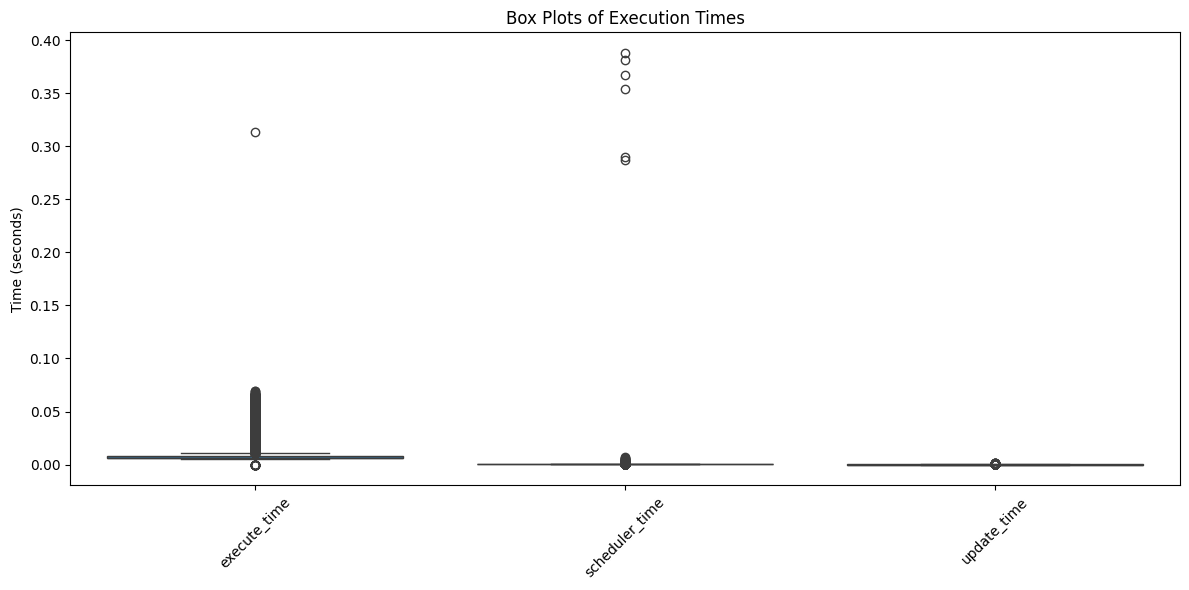

In [51]:
# create box plots for 'execute_time', 'scheduler_time', and 'update_time'
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['execute_time', 'scheduler_time', 'update_time']])
plt.title('Box Plots of Execution Times')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()